# Movie plot analysis

#### We will inspect the plot of movies to detect any change in lexical fields with respect to 9/11.

In [1]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from collections import Counter
from itertools import chain

In [2]:
#Load the data
movies = pd.read_pickle('../data/movies.pkl')
plot_summaries = pd.read_pickle('../data/plot_summaries.pkl')

movies_and_plot = pd.merge(left=movies, right=plot_summaries, on='Wikipedia_movie_ID')
movies_and_plot.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language,FirstLanguage_Name,SecondLanguage_Name,FirstCountry_Name,SecondCountry_Name,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",1,1,7,[English ],English,None,United States of America,None,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1,1,3,[English ],English,None,United Kingdom,None,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1,1,1,[German ],German,None,Germany,None,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",1,1,4,[English ],English,None,South Africa,None,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1,1,7,[English ],English,None,United States of America,None,"Adam, a San Francisco-based artist who works a..."


### Clustering

In [3]:
df_plots = movies_and_plot[['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Plot']]
df_plots

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...
35966,23851782,/m/06_vb43,The Ghost Train,1941-05-03 00:00:00+00:00,{{plot}} The film opens with a Great Western e...
35967,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19 00:00:00+00:00,Two former National Oceanic Atmospheric Admini...
35968,34980460,/m/0g4pl34,Knuckle,2011-01-21 00:00:00+00:00,{{No plot}} This film follows 12 years in the ...
35969,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21 00:00:00+00:00,"The story takes place in the year 2092,The Sup..."


In [4]:
def expected_number_before_after(df, split=2003, without_n_most_common=None):
    df_plots_after = df[df['Movie_release_date'].dt.year > split]
    df_plots_before = df[df['Movie_release_date'].dt.year <= split]

    plots_before = df_plots_before['Plot'].apply(lambda x: x.lower().strip("',.{[}]!?|").split()).to_list()
    plots_after = df_plots_after['Plot'].apply(lambda x: x.lower().strip("',.{[}]!?|").split()).to_list()

    text_before = list(chain.from_iterable(plots_before))
    text_after = list(chain.from_iterable(plots_after))
    
    counter_all = Counter(text_before)
    counter_all.update(text_after)
    
    counter_before = Counter(text_before)
    counter_after = Counter(text_after)

    dict_all, dict_before, dict_after = dict(counter_all), dict(counter_before), dict(counter_after)

    for k, v in dict_all.items():
        dict_all[k] = v / len(df_plots)

    for k, v in dict_before.items():
        dict_before[k] = v / len(df_plots_before)

    for k, v in dict_after.items():
        dict_after[k] = v / len(df_plots_after)

    for key in dict_all.keys():
        if key not in dict_before:
            dict_before[key] = 0
        if key not in dict_after:
            dict_after[key] = 0
    
    if without_n_most_common is not None:
        for word, count in counter_all.most_common(without_n_most_common):
            dict_all.pop(word)
            dict_before.pop(word)
            dict_after.pop(word)

    dict_all = dict(sorted(dict_all.items()))
    dict_before = dict(sorted(dict_before.items()))
    dict_after = dict(sorted(dict_after.items()))

    return counter_all, dict_all, counter_before, dict_before, counter_after, dict_after

In [5]:
counter_all, dict_all, counter_before, dict_before, counter_after, dict_after = expected_number_before_after(df=df_plots, split=2002, without_n_most_common=60)

In [6]:
def ratios_before_after(dict_before, dict_after, min_expectation=1e-2):
    sorted_tuples = []

    for key, val_bef, val_aft in zip(dict_before.keys(), dict_before.values(), dict_after.values()):
        if val_bef < min_expectation or val_aft < min_expectation:
            ratio = 1
        else:
            ratio = val_aft / val_bef

        sorted_tuples.append((key, ratio))

    sorted_tuples = sorted(sorted_tuples, key=lambda item: item[1])

    sorted_words = [el[0] for el in sorted_tuples]
    sorted_ratios = [el[1] for el in sorted_tuples]

    return sorted_words, sorted_ratios

In [7]:
sorted_words, sorted_ratios = ratios_before_after(dict_before, dict_after, 1e-3)
sorted_pairs = list(zip(sorted_words, sorted_ratios))

In [8]:
sorted_pairs[-30:]

[('vamsi', 5.205451838579203),
 ('jared', 5.207806181337491),
 ('caleb', 5.257247379261583),
 ('sin', 5.3025684773586645),
 ('mumbai,', 5.36601801469458),
 ('shaggy', 5.438531771649912),
 ('flynn', 5.476038887316463),
 ('lindsey', 5.516225082673483),
 ('julien', 5.551053118649565),
 ('cricket', 5.605871210777603),
 ('infected', 5.639176633128259),
 ('ian', 5.6802442948343534),
 ('izzy', 5.735178959194452),
 ('santiago', 5.743089550862308),
 ('janie', 5.9329437508908125),
 ('aditya', 6.057031463327746),
 ('shane', 6.123383920672494),
 ('dylan', 6.242488642241639),
 ('celeste', 6.370851503932754),
 ('bloom', 6.848521490225815),
 ('shrek', 6.901309282645406),
 ('website', 7.432660087921548),
 ('garfield', 7.976513265086537),
 ('ria', 8.1376549472095),
 ('sanjana', 8.22412121566572),
 ('evan', 10.415612362674983),
 ('kabir', 10.542384665044446),
 ('mia', 10.877063543299824),
 ('jenna', 12.801467093268256),
 ('nate', 13.574575302038182)]

In [10]:
sorted_words, sorted_ratios = ratios_before_after(dict_before, dict_after)
sorted_pairs = list(zip(sorted_words, sorted_ratios))

In [11]:
sorted_pairs[-30:]

[('haunted', 1.9205526423734418),
 ('memory', 1.9209076006830332),
 ('dark', 1.9407363376915099),
 ('journey', 1.949445543499863),
 ('khan', 1.986246386167794),
 ('phone', 2.0222146305853195),
 ('terrorist', 2.05690773620378),
 ('ryan', 2.0703501630712737),
 ('alex', 2.0887022372714084),
 ('team.', 2.1031665301435822),
 ('ghost', 2.1137613363497634),
 ('web', 2.116083271151057),
 ('ben', 2.1368897752774445),
 ('dave', 2.160270624840986),
 ('korean', 2.1662337520833406),
 ('reality', 2.205111175672388),
 ('lucky', 2.2070550753313825),
 ('patrick', 2.215255432261796),
 ('team,', 2.21927183585069),
 ('sarah', 2.221005190577988),
 ('soul', 2.2328493478325053),
 ('adam', 2.242520555713743),
 ('india', 2.3123831384644813),
 ('sara', 2.332482218310504),
 ('claire', 2.4807337905771534),
 ('sean', 2.610495250391958),
 ('cell', 2.6280606946233735),
 ('kim', 2.721160844630409),
 ('video', 2.78109606141912),
 ('emma', 2.7917796427802886)]

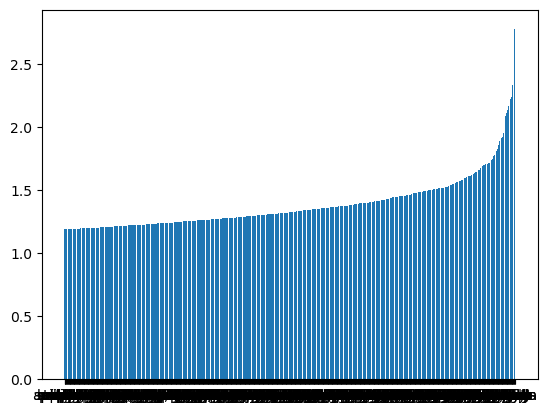

In [15]:
plt.bar(sorted_words[-1000:], sorted_ratios[-1000:])
plt.show()

In [ ]:
plt.scatter(dict_before.values(), dict_after.values())
plt.plot(np.array([0, 0.4]), np.array([0, 0.4]), color='darkviolet')
plt.scatter(dict_before['shrek'], dict_after['shrek'], color='lime')
plt.xlabel('Expected number of word in one plot before')
plt.ylabel('Expected number of word in one plot after')

plt.show()

In [ ]:
# for the lolz
w = 'shrek'
print(dict_before[w])
print(dict_after[w])

#### Let us first analyse the plots in a simple manner. Let us check the number of occurences of key words in plots. 

In [ ]:
key_words = ['plane', 'tower', 'twin tower', 'terrorism', 'terrorist', 'hijack', 'islam', 'world trade center']
df_plots = movies_and_plot[['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Plot']]

In [ ]:

def flag_plot_movie(df, key_words):
    pd.options.mode.chained_assignment = None
    col_name_of_key_words = [word.lower() for word in key_words]

    def flag_count(plot_summary, key_word):
        return 1 if plot_summary.lower().count(key_word) > 0 else 0

    for i in range(len(key_words)):
        col_name = col_name_of_key_words[i][0].upper() + col_name_of_key_words[i][1:]
        df[col_name] = df['Plot'].apply(lambda x: flag_count(x, key_word=col_name_of_key_words[i]))

    pd.options.mode.chained_assignment = 'warn'
    return df


df_plots_flagged = flag_plot_movie(df=df_plots, key_words=key_words)
df_plots_flagged

In [ ]:
def occ_by_year(df, key_words):
    col_name_of_key_words = [word[0].upper() + word[1:] for word in key_words]
    df_key_words_occ = df.groupby(by=df['Movie_release_date'].dt.year)[col_name_of_key_words].sum()
    df_key_words_occ['Movies'] = df.groupby(by=df['Movie_release_date'].dt.year)['Wikipedia_movie_ID'].count()

    return df_key_words_occ.copy(deep=True)


df_key_words_occ = occ_by_year(df=df_plots_flagged, key_words=key_words)
df_key_words_occ


In [ ]:
def plot_occ_by_year(df, key_words):
    col_name_of_key_words = [word[0].upper() + word[1:] for word in key_words]
    fig, ax = plt.subplots(math.ceil(len(key_words)/2), 2, figsize= (math.ceil(len(key_words)/2)*6, 8), sharey = True, sharex = True)

    for i in range(len(key_words)):
        sbplt = ax[i%math.ceil(len(key_words)/2), math.floor(i/math.ceil(len(key_words)/2))]
        col_name = col_name_of_key_words[i]

        sbplt.plot(df[col_name])
        sbplt.set_title('Occurence of word "' + col_name_of_key_words[i] + '" in plot summaries')
        
    if (len(key_words) % 2 != 0):
        fig.delaxes(ax[math.floor(len(key_words)/2), 1])

    fig.tight_layout()

    fig.text(0.48,0, "Year of release")
    fig.text(0,0.32, "Number of movie plots with the key word", rotation = 90)


plot_occ_by_year(df_key_words_occ, key_words)

#### Now by percentage 

In [ ]:
def percentage_of_movies_with_key_words_before_after(df, mid_value=2003, horizon_years=10):
    df_occ= df.reset_index()
    before_horizon = mid_value - horizon_years
    after_horizon = mid_value + horizon_years

    df_occ_before = df_occ[(before_horizon <= df_occ['Movie_release_date']) * (df_occ['Movie_release_date'] < mid_value) == 1]
    df_occ_after = df_occ[(mid_value <= df_occ['Movie_release_date'])  * (df_occ['Movie_release_date'] < after_horizon) == 1]

    df_res = pd.DataFrame(data={
    f'{before_horizon}-{mid_value - 1}': df_occ_before.sum() / df_occ_before['Movies'].sum(),
    f'{mid_value}-{after_horizon - 1}': df_occ_after.sum() / df_occ_after['Movies'].sum()
    })

    df_res = df_res.drop(['Movie_release_date', 'Movies']).map(lambda x: str(round(x*100, 2)) + '%')

    return df_res

In [ ]:
df_percentage_before_after = percentage_of_movies_with_key_words_before_after(df=df_key_words_occ, horizon_years=10)
df_percentage_before_after

It is interesting to see that the percentage of movies that contain the word "plane" is less used after 9/11 than before, even though you would expect to have more.